In [86]:
import numpy as np
from math import log, pi
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_array, check_X_y, check_is_fitted

class RBFKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting.

    Parameters
    ----------
    k : int, default=sqrt(n_training_samples)
        Number of neighbors to consider.
    h : float, default=\frac{e^{-1}}{mean(dist_training_samples)^{-2}+mean(dist_training_samples)^{-1/2}}
        Radius (std. deviation) of the isotropic RBF (covariance = h^2 * I).
    """

    def default_k(self, n_samples):
        return int(np.floor(np.sqrt(n_samples)))

    def default_h(self, n_samples, X):
        # compute average pairwise distance (inefficient for large n_samples)
        dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
        mean_dist = np.sum(dists) / (n_samples * (n_samples - 1))  # exclude self-distances
        return np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5)

    def __init__(self, k: int | None = None, h: float | None = None):
        self.k_ = k
        self.h_ = h

    def pre_fit(self, X, y):
        X, y = check_X_y(X, y, ensure_min_samples=1, dtype=float)
        return X, y

    def fit(self, X, y):
        X, y = self.pre_fit(X, y)

        n_samples, n_features = X.shape

        # default k: sqrt(n_samples)
        if self.k_ is None:
            self.k_ = self.default_k(n_samples)

        # default h: based on average pairwise distance in training set
        if self.h_ is None:
            self.h_ = self.default_h(n_samples, X)


        if self.h_ <= 0:
            raise ValueError("h must be > 0 (standard deviation of RBF).")
        
        k_eff = min(max(1, self.k_), n_samples)

        # store data
        self.X_ = X.copy()
        self.y_ = np.asarray(y).copy()
        self.n_features_in_ = n_features

        # classes and integer-encoded labels
        self.classes_, inv = np.unique(self.y_, return_inverse=True)
        self._y_encoded = inv  # length n_samples, values in [0, n_classes-1]
        self.n_classes_ = self.classes_.shape[0]

        # nearest-neighbor structure
        self._k_eff = k_eff
        self._nn = NearestNeighbors(n_neighbors=self._k_eff)
        self._nn.fit(self.X_)

        return self

    def _rbf_logpdf_const(self):
        # constant term of isotropic multivariate normal log-pdf

        if self.k_ is None or self.h_ is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        d = self.n_features_in_
        return -0.5 * d * (np.log(2 * pi) + np.log(self.h_ * self.h_))
    
    def kernel(self, X):
        check_is_fitted(self, attributes=['X_', 'y_', '_nn', 'k_', 'h_'])
        X = check_array(X, dtype=float)
        n_test = X.shape[0]

        if self.k_ is None or self.h_ is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        # get k nearest neighbors (distances returned in Euclidean norm)
        dists, idxs = self._nn.kneighbors(X, n_neighbors=self._k_eff, return_distance=True)
        # dists shape (n_test, k), idxs same shape
        dists_sq = dists ** 2  # squared euclidean distances

        # compute log-weights for each neighbor: logpdf of N(mu=neighbor, cov=h^2 I)
        const = self._rbf_logpdf_const()
        logw = const - 0.5 * (dists_sq / (self.h_ * self.h_))  # shape (n_test, k)

        # numerical stabilization: subtract max per row before exponentiation
        max_logw = np.max(logw, axis=1, keepdims=True)
        stable_w = np.exp(logw - max_logw)  # now safe to exponentiate

        # accumulate weighted votes per class
        probs = np.zeros((n_test, self.n_classes_), dtype=float)
        neighbor_classes = self._y_encoded[idxs]  # shape (n_test, k)

        # vectorized accumulation per sample using bincount (loop over tests)
        for i in range(n_test):
            w = stable_w[i]
            cls_idx = neighbor_classes[i]
            # sum weights for each class among neighbors
            counts = np.bincount(cls_idx, weights=w, minlength=self.n_classes_)
            probs[i, :] = counts

        return probs, neighbor_classes

    def predict_proba(self, X):
        probs, neighbor_classes = self.kernel(X)

        # normalize to probabilities
        row_sums = probs.sum(axis=1, keepdims=True)
        # if any row sums are zero (unlikely due to stabilization), assign uniform over neighbor classes
        zero_mask = (row_sums.squeeze() == 0)
        if zero_mask.any():
            for i in np.nonzero(zero_mask)[0]:
                present = np.unique(neighbor_classes[i])
                probs[i, :] = 0.0
                probs[i, present] = 1.0 / present.size
            row_sums = probs.sum(axis=1, keepdims=True)

        probs /= row_sums
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def likelihood_space(self):
        """
        Returns the training data projection in the likelihood space.
        """
        likelihoods, _ = self.kernel(self.X_)

        # Normalize by the max likelihood to ensure the domain is [0, 1]
        likelihoods /= np.max(likelihoods)

        return likelihoods


In [87]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0) #type: ignore
clf_ref = RBFKNeighborsClassifier()
clf_ref.fit(X_train, y_train)
print("Accuracy:", clf_ref.score(X_test, y_test))
probs = clf_ref.predict_proba(X_test[:5])
print("Probs for first 5 test samples:\n", probs)


Accuracy: 0.9736842105263158
Probs for first 5 test samples:
 [[0.         0.06962706 0.93037294]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]]


Test accuracy: 0.9273  (k=13, h=0.3469924031835624)


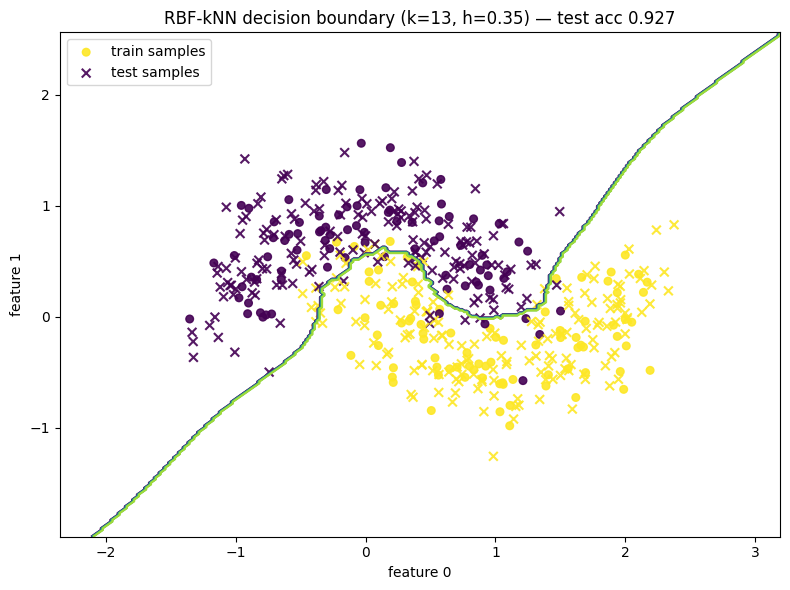

In [88]:
"""
Example: RBF-weighted k-NN on the Moons dataset with DecisionBoundaryDisplay.

Requirements
------------
- numpy
- matplotlib
- scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# --- Configuration ---
k_ = None         # number of neighbors - use default sqrt(n_samples)
h_ = None         # RBF radius (std. dev.) - use default based on training set
random_state = 0
n_samples = 500
noise = 0.25

# --- Prepare data ---
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.66, stratify=y, random_state=random_state
)

# --- Build pipeline: scaling + classifier ---
clf_ref = RBFKNeighborsClassifier(k=k_, h=h_)  # use your implementation
pipe = make_pipeline(StandardScaler(), clf_ref)

# --- Fit and evaluate ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)
print(f"Test accuracy: {acc:.4f}  (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_})")

# --- Decision boundary visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# DecisionBoundaryDisplay will plot the decision function (here we use predict)
# The 'from_estimator' helper handles creating the mesh and plotting contours.
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,                # bounds are derived from these points
    response_method="predict",
    plot_method="contour",
    ax=ax, #type: ignore
    grid_resolution=300,
    
)

# Overlay training points (color-coded by class)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)

ax.set_title(f"RBF-kNN decision boundary (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_:.2f}) — test acc {acc:.3f}")
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [89]:
def gabriel_graph(X):
    """
    Compute the Gabriel graph matrix for a set of points.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points
        
    Returns
    -------
    adjacency_matrix : ndarray of shape (n_samples, n_samples)
        Binary adjacency matrix where 1 indicates an edge and 0 indicates no edge
    """
    X = np.asarray(X)
    n_points = X.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=int)
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            # Midpoint of edge (i, j)
            midpoint = (X[i] + X[j]) / 2
            # Radius of the circle (half the distance between i and j)
            radius = np.linalg.norm(X[i] - X[j]) / 2
            
            # Check if any other point lies inside the circle
            is_gabriel_edge = True
            for k in range(n_points):
                if k != i and k != j:
                    dist_to_midpoint = np.linalg.norm(X[k] - midpoint)
                    if dist_to_midpoint < radius:
                        is_gabriel_edge = False
                        break
            
            if is_gabriel_edge:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    
    return adjacency_matrix

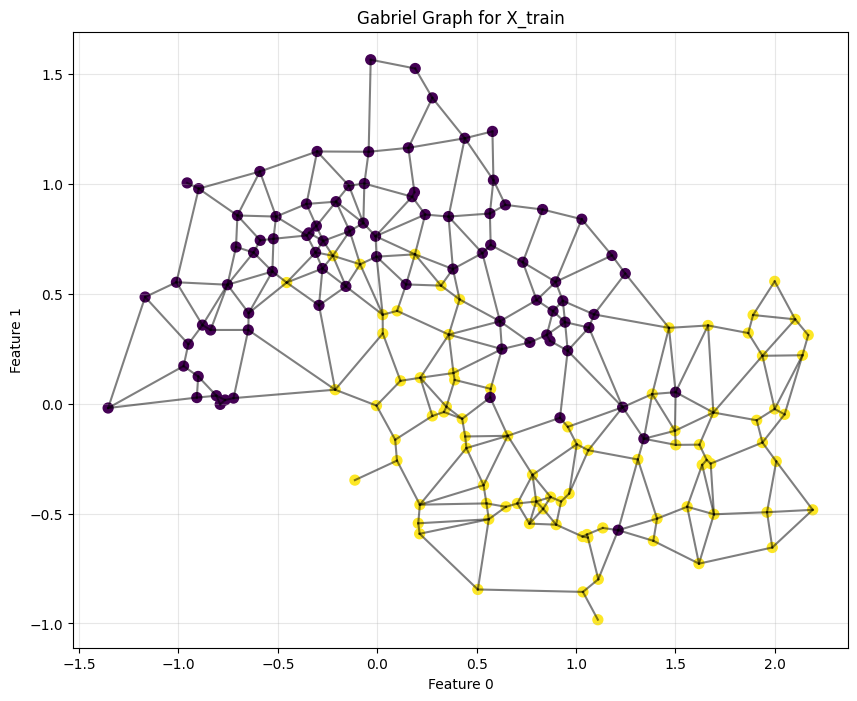

Number of points: 170
Number of Gabriel graph edges: 324
Maximum possible edges: 14365


In [90]:
# Compute Gabriel graph for X_train
gabriel_adj = gabriel_graph(X_train)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot the points colored by class
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, label='Points', cmap='viridis')

# Draw edges for Gabriel graph
n_points = X_train.shape[0]
for i in range(n_points):
    for j in range(i + 1, n_points):
        if gabriel_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'k', alpha=0.5)

plt.title('Gabriel Graph for X_train')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
n_edges = np.sum(gabriel_adj) // 2  # divide by 2 since matrix is symmetric
print(f"Number of points: {n_points}")
print(f"Number of Gabriel graph edges: {n_edges}")
print(f"Maximum possible edges: {n_points * (n_points - 1) // 2}")

In [91]:
def support_graph(gabriel_adj, y):
    """
    Return an adjacency matrix indicating Gabriel edges between points of different classes.
    
    Parameters
    ----------
    gabriel_adj : array-like of shape (n_samples, n_samples)
        Binary adjacency matrix of Gabriel graph
    y : array-like of shape (n_samples,)
        Class labels for each sample
        
    Returns
    -------
    support_graph_matrix : ndarray of shape (n_samples, n_samples)
        Binary matrix where 1 indicates a Gabriel edge between points of different classes
    """
    gabriel_adj = np.asarray(gabriel_adj)
    y = np.asarray(y)
    n_samples = gabriel_adj.shape[0]
    
    # Create matrix indicating different classes
    different_classes = (y[:, np.newaxis] != y[np.newaxis, :]).astype(int)
    
    # Element-wise multiplication: 1 only if Gabriel edge AND different classes
    support_graph_matrix = gabriel_adj * different_classes

    return support_graph_matrix

In [92]:
def support_vectors(X, y, support_graph_matrix):
    """
    Identify support vectors based on the support graph matrix.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points
    y : array-like of shape (n_samples,)
        Class labels for each sample
    support_graph_matrix : array-like of shape (n_samples, n_samples)
        Binary adjacency matrix indicating Gabriel edges between points of different classes
        
    Returns
    -------
    support_vectors: ndarray of shape (m, n_features)
        Points that are support vectors (connected to at least one point of a different class)
    """
    support_graph_matrix = np.asarray(support_graph_matrix)
    
    # A point is a support vector if it has at least one edge in the support graph
    is_support_vector = np.any(support_graph_matrix, axis=1)

    return X[is_support_vector], y[is_support_vector]

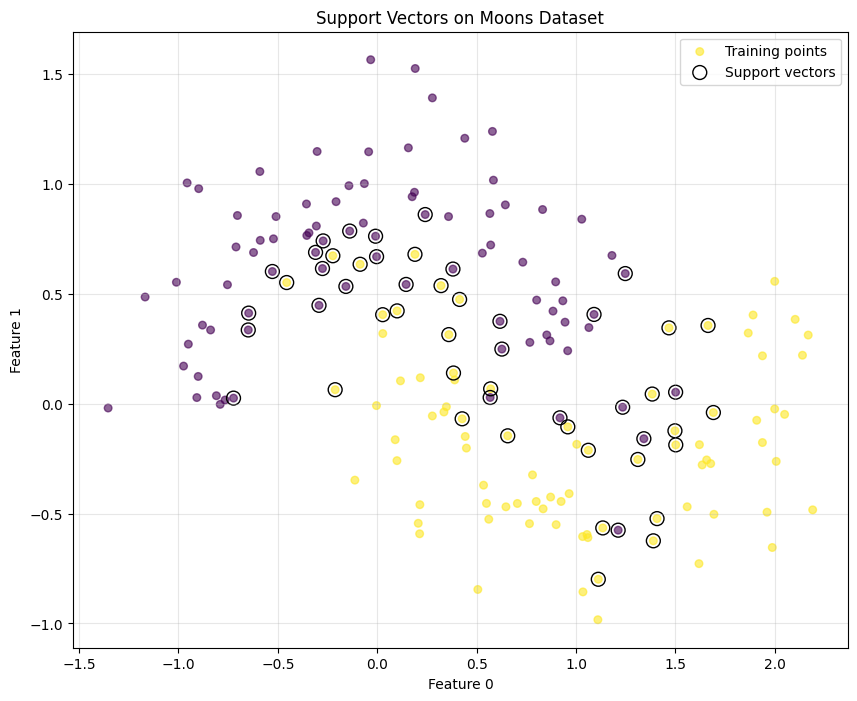

Total training points: 170
Number of support vectors: 52
Percentage of support vectors: 30.6%


In [93]:
# Compute support graph and support vectors for the training data
support_graph_mat = support_graph(gabriel_adj, y_train)
X_sup, _ = support_vectors(X_train, y_train, support_graph_mat)

# Create visualization of support vectors
plt.figure(figsize=(10, 8))

# Plot all training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, alpha=0.6, 
           label='Training points', cmap='viridis')

# Highlight support vectors
plt.scatter(X_sup[:, 0], X_sup[:, 1], 
           s=100, facecolors='none', edgecolors='black', linewidth=1,
           label='Support vectors')

plt.title('Support Vectors on Moons Dataset')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training points: {len(X_train)}")
print(f"Number of support vectors: {len(X_sup)}")
print(f"Percentage of support vectors: {len(X_sup)/len(X_train)*100:.1f}%")

In [94]:
from scipy.spatial import cKDTree

def gabriel_approx(X):
    """
    Hyperparameter-free approximate Gabriel graph.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points

    Returns
    -------
    adjacency_matrix : ndarray of shape (n_samples, n_samples)
        Binary adjacency matrix where 1 indicates an edge and 0 indicates no edge
    """
    X = np.asarray(X)
    n, d = X.shape
    
    if n <= 1:
        return np.zeros((n, n), dtype=int)

    # Data-driven choices for number of projections and neighbor window
    m = max(1, int(np.ceil(np.log2(n))))
    w = max(2, int(np.ceil(np.log2(n))))

    # deterministic seed derived from X
    # create a cheap hash from rounded coordinates
    flat = np.floor(X.ravel() * 1e6).astype(np.int64)
    seed = int((flat.sum() ^ (flat.prod() if flat.size<100 else flat[:100].sum())) & 0xFFFFFFFF)
    rng = np.random.RandomState(seed)

    # build KD-tree for radius queries
    tree = cKDTree(X)

    # prepare projection vectors
    vs = rng.normal(size=(m, d))
    # normalize
    vs /= np.linalg.norm(vs, axis=1, keepdims=True)

    candidates = set()
    for v in vs:
        s = X.dot(v)
        order = np.argsort(s)
        # neighbor window in 1-D ordering
        for pos, i in enumerate(order):
            lo = max(0, pos - w)
            hi = min(n - 1, pos + w)
            # enumerate neighbor indices in the ordering
            for qpos in range(lo, hi + 1):
                j = order[qpos]
                if i < j:
                    candidates.add((i, j))
                elif j < i:
                    candidates.add((j, i))

    # epsilon for numeric robustness (data-driven)
    max_abs = np.max(np.abs(X)) if X.size > 0 else 1.0
    eps = 1e-12 + np.finfo(float).eps * (max_abs + 1.0)

    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((n, n), dtype=int)
    
    # check Gabriel property for each candidate pair
    # use KD-tree radius query
    for (i, j) in candidates:
        pi = X[i]
        pj = X[j]
        mid = (pi + pj) * 0.5
        r = 0.5 * np.linalg.norm(pi - pj)
        # query for any point within radius r + tiny_eps
        idxs = tree.query_ball_point(mid, r + eps)
        # remove i and j if present
        has_other = any(k != i and k != j for k in idxs)
        if not has_other:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1

    return adjacency_matrix

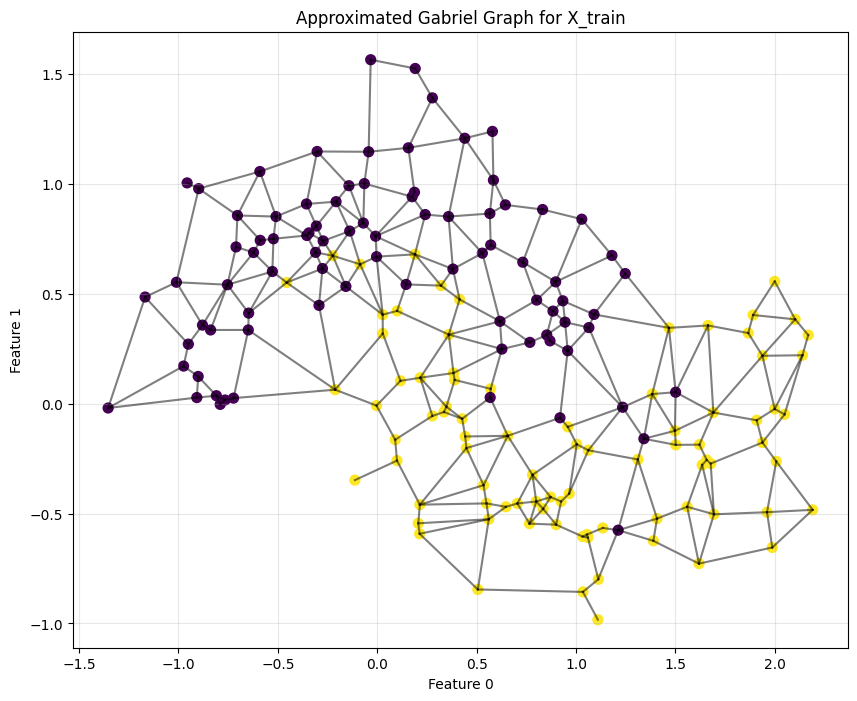

Number of points: 170
Number of approximated Gabriel graph edges: 324
Maximum possible edges: 14365


In [95]:
# Compute approximated Gabriel graph for X_train
gabriel_approx_adj = gabriel_approx(X_train)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot the points colored by class
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, label='Points', cmap='viridis')

# Draw edges for approximated Gabriel graph
n_points = X_train.shape[0]
for i in range(n_points):
    for j in range(i + 1, n_points):
        if gabriel_approx_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'k', alpha=0.5)

plt.title('Approximated Gabriel Graph for X_train')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
n_edges = np.sum(gabriel_approx_adj) // 2  # divide by 2 since matrix is symmetric
print(f"Number of points: {n_points}")
print(f"Number of approximated Gabriel graph edges: {n_edges}")
print(f"Maximum possible edges: {n_points * (n_points - 1) // 2}")

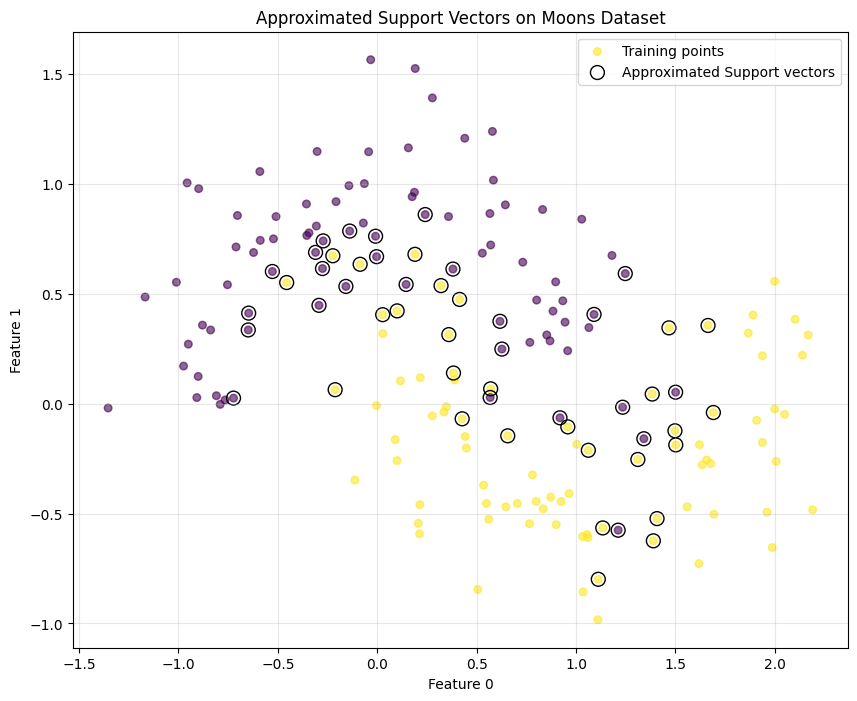

Total training points: 170
Number of approximated support vectors: 52
Percentage of approximated support vectors: 30.6%


In [96]:
# Compute support graph and support vectors for the training data
support_approx_mat = support_graph(gabriel_approx_adj, y_train)
X_sup, _ = support_vectors(X_train, y_train, support_approx_mat)

# Create visualization of support vectors
plt.figure(figsize=(10, 8))

# Plot all training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, alpha=0.6, 
           label='Training points', cmap='viridis')

# Highlight support vectors
plt.scatter(X_sup[:, 0], X_sup[:, 1], 
           s=100, facecolors='none', edgecolors='black', linewidth=1,
           label='Approximated Support vectors')

plt.title('Approximated Support Vectors on Moons Dataset')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training points: {len(X_train)}")
print(f"Number of approximated support vectors: {len(X_sup)}")
print(f"Percentage of approximated support vectors: {len(X_sup)/len(X_train)*100:.1f}%")

In [97]:
class SVRBFKNeighborsClassifier(RBFKNeighborsClassifier):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting,
    using only support vectors from the Gabriel graph between classes.
    """

    sv_mask: np.ndarray

    def pre_fit(self, X, y):
        X, y = super().pre_fit(X, y)
        gabriel_adj = gabriel_approx(X)
        support_graph_mat = support_graph(gabriel_adj, y)
        X_sup, y_sup = support_vectors(X, y, support_graph_mat)

        self.sv_mask = np.any(support_graph_mat, axis=1)

        return X_sup, y_sup

In [98]:
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0) #type: ignore

clf_ref = RBFKNeighborsClassifier()
clf_ref.fit(X_train, y_train)

clf_sv = SVRBFKNeighborsClassifier()
clf_sv.fit(X_train, y_train)

ref_acc = clf_ref.score(X_test, y_test)
sv_acc = clf_sv.score(X_test, y_test)

print(f"Reference k-NN accuracy: {ref_acc:.3f} (using {len(X_train)} points)")
print(f"Support-vector k-NN accuracy: {sv_acc:.3f} (using {len(clf_sv.X_)} points)")



Reference k-NN accuracy: 0.974 (using 112 points)
Support-vector k-NN accuracy: 0.632 (using 23 points)


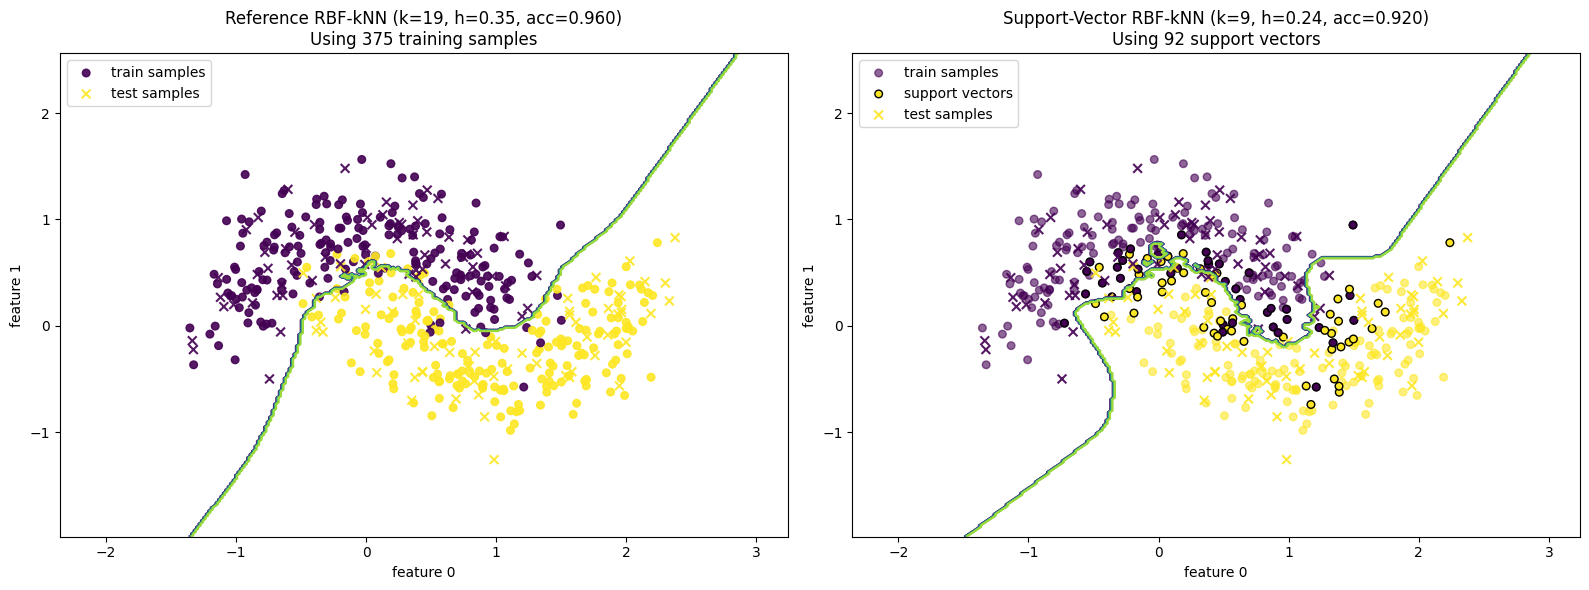

In [99]:
random_state = 0
n_samples = 500
noise = 0.25

# --- Prepare data ---
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_state
)

# --- Build reference pipeline: scaling + classifier ---
clf_ref = RBFKNeighborsClassifier()
pipe = make_pipeline(StandardScaler(), clf_ref)

# --- Fit and evaluate reference ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)

# --- Build support-vector pipeline: scaling + classifier ---
clf_sv = SVRBFKNeighborsClassifier()
pipe_sv = make_pipeline(StandardScaler(), clf_sv)

# --- Fit and evaluate support-vector ---
pipe_sv.fit(X_train, y_train)
sv_acc = pipe_sv.score(X_test, y_test)

# --- Decision boundary visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Reference classifier
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax1,
    grid_resolution=300,
)

ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)
ax1.set_title(f"Reference RBF-kNN (k={pipe.named_steps['rbfkneighborsclassifier'].k_}, h={pipe.named_steps['rbfkneighborsclassifier'].h_:.2f}, acc={acc:.3f})\nUsing {len(X_train)} training samples")
ax1.set_xlabel("feature 0")
ax1.set_ylabel("feature 1")
ax1.legend(loc="upper left")

# Right plot: Support vector classifier
DecisionBoundaryDisplay.from_estimator(
    pipe_sv,
    X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax2,
    grid_resolution=300,
)

sv_mask = pipe_sv.named_steps['svrbfkneighborsclassifier'].sv_mask

X_sup, y_sup = X_train[sv_mask], y_train[sv_mask]

ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.6)
ax2.scatter(X_sup[:, 0], X_sup[:, 1], c=y_sup, s=30, edgecolors='black', label="support vectors")
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)
ax2.set_title(f"Support-Vector RBF-kNN (k={pipe_sv.named_steps['svrbfkneighborsclassifier'].k_}, h={pipe_sv.named_steps['svrbfkneighborsclassifier'].h_:.2f}, acc={sv_acc:.3f})\nUsing {len(X_sup)} support vectors")
ax2.set_xlabel("feature 0")
ax2.set_ylabel("feature 1")
ax2.legend(loc="upper left")
plt.tight_layout()
plt.show()

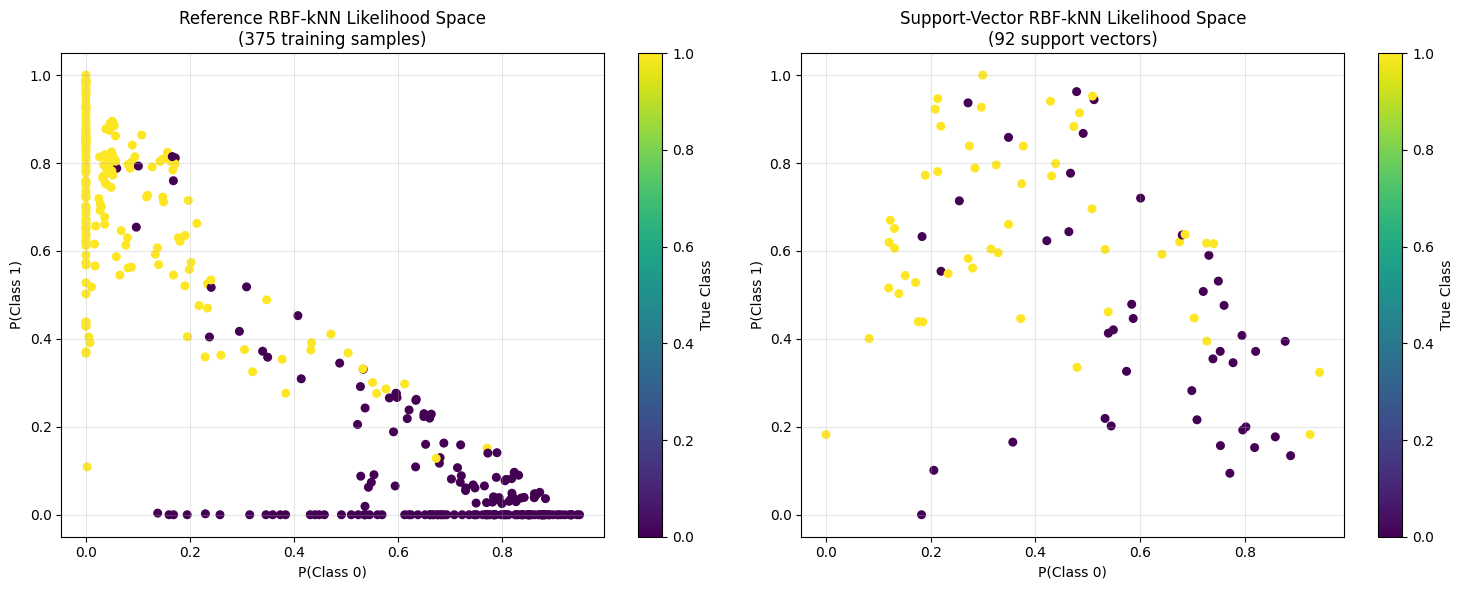

Reference model likelihood space shape: (375, 2)
Support vector model likelihood space shape: (92, 2)


In [100]:
# Get likelihood space for both models
likelihood_ref = clf_ref.likelihood_space()
likelihood_sv = clf_sv.likelihood_space()

# Create visualization of likelihood spaces
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Reference classifier likelihood space
scatter1 = ax1.scatter(likelihood_ref[:, 0], likelihood_ref[:, 1], 
                      c=y_train, s=30, cmap='viridis')
ax1.set_xlabel('P(Class 0)')
ax1.set_ylabel('P(Class 1)')
ax1.set_title(f'Reference RBF-kNN Likelihood Space\n({len(X_train)} training samples)')
ax1.grid(True, alpha=0.3)

# Right plot: Support vector classifier likelihood space
scatter2 = ax2.scatter(likelihood_sv[:, 0], likelihood_sv[:, 1], 
                      c=y_train[sv_mask], s=30, cmap='viridis')
ax2.set_xlabel('P(Class 0)')
ax2.set_ylabel('P(Class 1)')
ax2.set_title(f'Support-Vector RBF-kNN Likelihood Space\n({len(X_sup)} support vectors)')
ax2.grid(True, alpha=0.3)

# Add colorbars
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('True Class')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('True Class')

plt.tight_layout()
plt.show()

print(f"Reference model likelihood space shape: {likelihood_ref.shape}")
print(f"Support vector model likelihood space shape: {likelihood_sv.shape}")

In [101]:
from sklearn.model_selection import StratifiedKFold

def plot_sweep_h(classifier_type, X, y, h_values, likelihood_space_metric):
    """
    Create a Pipeline with scaling and the given classifier type.
    Sweep over h values, fit the model, and plot test accuracy and likelihood space metric.
    
    Parameters
    ----------
    classifier_type : type
        The type of classifier to use
    X : array-like of shape (n_samples, n_features)
        Input features
    y : array-like of shape (n_samples,)
        Class labels
    h_values : list or array-like
        List of h values to sweep over
    likelihood_space_metric : callable
        Function to compute a metric from the likelihood space (e.g., variance)
    
    Returns
    -------
    h_max_acc : float
        h value that gives the maximum test accuracy
    h_max_metric : float
        h value that gives the maximum likelihood space metric
    h_default : float
        mean h value computed by the classifier's default method
    """
    cv = StratifiedKFold(shuffle=True, random_state=0)
    
    accuracies = []
    metrics = []
    default_hs = []
    
    for h in h_values:
        clf = classifier_type(h=h)
        pipe = make_pipeline(StandardScaler(), clf)
        
        fold_accuracies = []
        fold_metrics = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Fit and evaluate accuracy
            pipe.fit(X_train_fold, y_train_fold)
            acc = pipe.score(X_val_fold, y_val_fold)
            fold_accuracies.append(acc)

            # Access the classifier step in the pipeline
            access_clf = pipe.named_steps[clf.__class__.__name__.lower()]
            
            # Compute likelihood space metric
            likelihood = access_clf.likelihood_space()
            metric_value = likelihood_space_metric(likelihood, access_clf.y_)
            fold_metrics.append(metric_value)

            # Store what would be the default h for this fold
            default_hs.append(access_clf.default_h(len(X_train_fold), X_train_fold))
        
        accuracies.append(np.mean(fold_accuracies))
        metrics.append(np.mean(fold_metrics))
    
    # Find optimal h values
    h_max_acc = h_values[np.argmax(accuracies)]
    h_max_metric = h_values[np.argmax(metrics)]

    # Compute mean default h
    h_default = float(np.mean(default_hs))

    # Normalize metrics for plotting
    metrics = np.array(metrics)
    metrics = (metrics - np.min(metrics)) / (np.max(metrics) - np.min(metrics)) if np.max(metrics) > np.min(metrics) else metrics

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(h_values, accuracies, label='Test Accuracy')
    plt.plot(h_values, metrics, label='Likelihood Space Metric')
    plt.axvline(h_max_acc, color='blue', linestyle='--', label=f'Optimal h (Acc): {h_max_acc:.2f}')
    plt.axvline(h_max_metric, color='orange', linestyle='--', label=f'Optimal h (Metric): {h_max_metric:.2f}')
    plt.axvline(h_default, color='green', linestyle='--', label=f'Default h: {h_default:.2f}')
    plt.xlabel('h value')
    plt.ylabel('Score / Metric (normalized)')
    plt.title(f'Sweep of h values for {classifier_type.__name__}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return h_max_acc, h_max_metric, h_default


In [102]:
def centroid_distance(Q, y):
    """
    Compute the distance between each pair of centroids in the likelihood space.

    Parameters
    ----------
    Q : array-like of shape (n_samples, n_classes)
        Probabilities of each sample to belong to each class.
    y : array-like of shape (n_samples,)
        Class label for each sample.

    Returns
    -------
    Dm : ndarray of shape (n_classes, n_classes)
        Distance matrix where Dm[i, j] is the Euclidean distance between centroid of class i and class j.
    dist_avg : float
        Average of the pairwise centroid distances (off-diagonal).
    dist_std : float
        Standard deviation of the pairwise centroid distances (off-diagonal).
    """
    Q = np.asarray(Q, dtype=float)
    y = np.asarray(y)

    classes = np.unique(y)
    n_classes = classes.size

    # compute centroid for each class in likelihood space
    centroids = np.zeros((n_classes, Q.shape[1]), dtype=float)
    for idx, cls in enumerate(classes):
        members = Q[y == cls]
        if members.size == 0:
            centroids[idx] = 0.0
        else:
            centroids[idx] = members.mean(axis=0)

    # pairwise Euclidean distances between centroids
    diff = centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]
    Dm = np.linalg.norm(diff, axis=2)

    # extract upper-triangular (off-diagonal) distances
    if n_classes > 1:
        triu_idx = np.triu_indices(n_classes, k=1)
        pairwise = Dm[triu_idx]
        dist_avg = float(np.mean(pairwise))
        dist_std = float(np.std(pairwise))
    else:
        dist_avg = 0.0
        dist_std = 0.0

    return Dm, dist_avg, dist_std

In [103]:
def test_likelihood_metric(metric, h_values = None):

    # Prepare h values
    if h_values is None:
        h_values = np.linspace(0.1, 1, 10)

    # Sweep for Reference RBF-kNN
    print("Sweeping h values for Reference RBF-kNN...")
    h_max_acc_ref, h_max_metric_ref, h_default_ref = plot_sweep_h(
        RBFKNeighborsClassifier, X, y, h_values, metric
    )

    # Sweep for Support Vector RBF-kNN
    print("\nSweeping h values for Support Vector RBF-kNN...")
    h_max_acc_sv, h_max_metric_sv, h_default_sv = plot_sweep_h(
        SVRBFKNeighborsClassifier, X, y, h_values, metric
    )

    print(f"\nResults Summary:")
    print(f"Reference RBF-kNN:")
    print(f"  h for max accuracy: {h_max_acc_ref:.3f}")
    print(f"  h for max avg centroid distance: {h_max_metric_ref:.3f}")
    print(f"  default h: {h_default_ref:.3f}")
    print(f"\nSupport Vector RBF-kNN:")
    print(f"  h for max accuracy: {h_max_acc_sv:.3f}")
    print(f"  h for max avg centroid distance: {h_max_metric_sv:.3f}")
    print(f"  default h: {h_default_sv:.3f}")

    dist_to_max_acc_ref = (h_max_metric_ref - h_max_acc_ref, h_default_ref - h_max_acc_ref)
    dist_to_max_acc_sv = (h_max_metric_sv - h_max_acc_sv, h_default_sv - h_max_acc_sv)

    return dist_to_max_acc_ref, dist_to_max_acc_sv


Sweeping h values for Reference RBF-kNN...


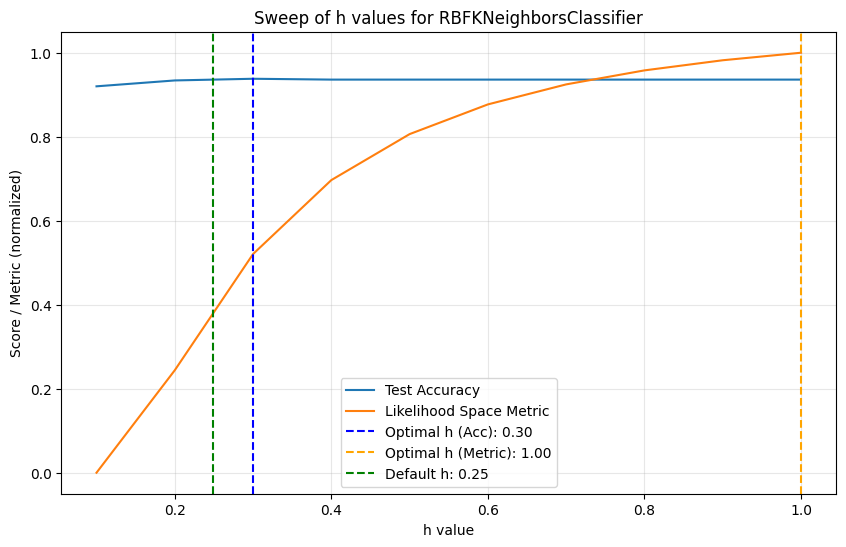


Sweeping h values for Support Vector RBF-kNN...


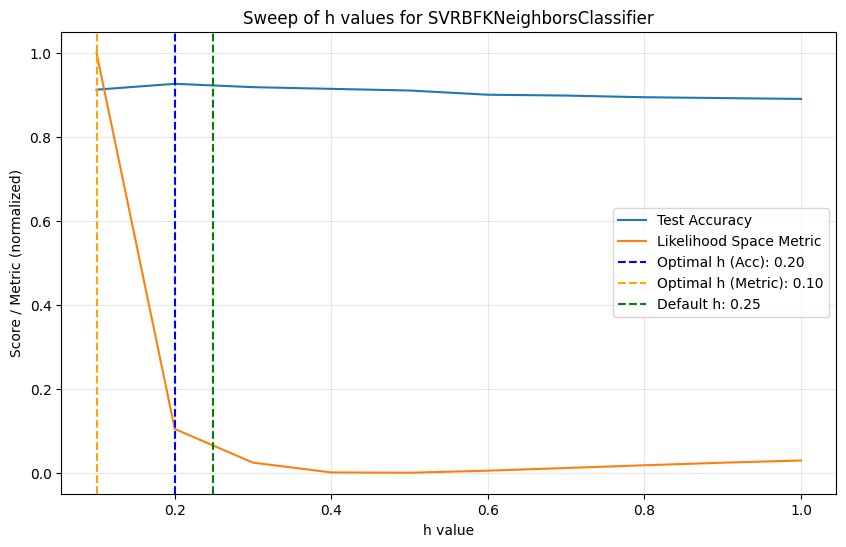


Results Summary:
Reference RBF-kNN:
  h for max accuracy: 0.300
  h for max avg centroid distance: 1.000
  default h: 0.249

Support Vector RBF-kNN:
  h for max accuracy: 0.200
  h for max avg centroid distance: 0.100
  default h: 0.249


((np.float64(0.7), np.float64(-0.051056649192925435)),
 (np.float64(-0.1), np.float64(0.0489433508070746)))

In [104]:
def avg_centroid_distance(Q, y):
    """Compute the average centroid distance in likelihood space"""
    _, dist_avg, _ = centroid_distance(Q, y)
    return dist_avg

test_likelihood_metric(avg_centroid_distance)

In [105]:
def sample_spread(Q, y):
    """
    Compute the average pairwise distance between samples in the likelihood space.

    Parameters
    ----------
    Q : array-like of shape (n_samples, n_classes)
        Probabilities of each sample to belong to each class.
    y : array-like of shape (n_samples,)
        Class label for each sample.

    Returns
    -------
    inter_class_avg : float
        Average pairwise distance between samples of different classes.
    intra_class_avg : float
        Average pairwise distance between samples of the same class.
    """
    Q = np.asarray(Q, dtype=float)
    y = np.asarray(y)

    n_samples = Q.shape[0]
    if n_samples <= 1:
        return 0.0, 0.0

    # pairwise Euclidean distances between samples
    diff = Q[:, np.newaxis, :] - Q[np.newaxis, :, :]
    D = np.linalg.norm(diff, axis=2)

    inter_class_dists = []
    intra_class_dists = []

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if y[i] == y[j]:
                intra_class_dists.append(D[i, j])
            else:
                inter_class_dists.append(D[i, j])

    intra_class_avg = float(np.mean(intra_class_dists)) if intra_class_dists else 0.0
    inter_class_avg = float(np.mean(inter_class_dists)) if inter_class_dists else 0.0

    return inter_class_avg, intra_class_avg    

Sweeping h values for Reference RBF-kNN...


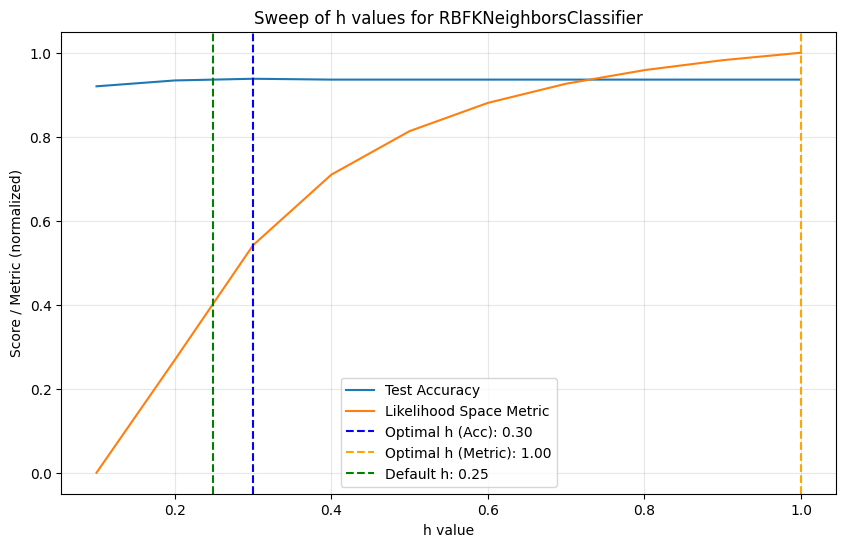


Sweeping h values for Support Vector RBF-kNN...


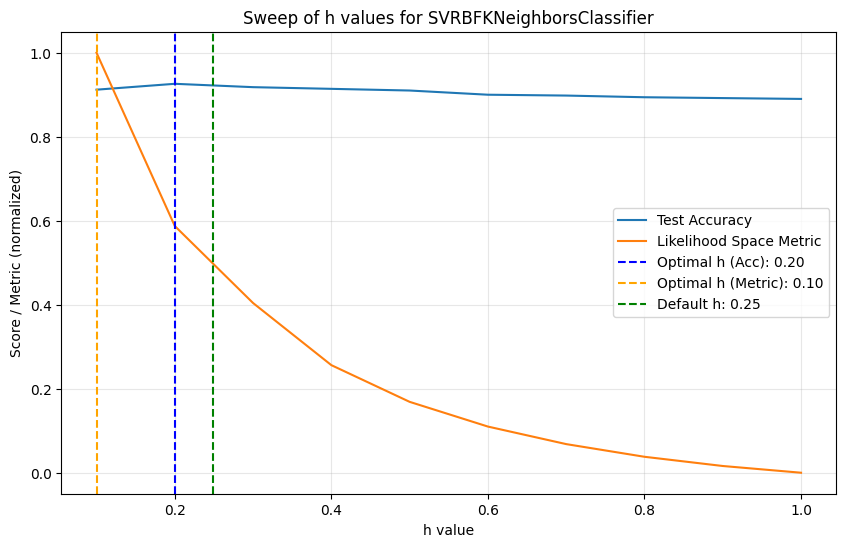


Results Summary:
Reference RBF-kNN:
  h for max accuracy: 0.300
  h for max avg centroid distance: 1.000
  default h: 0.249

Support Vector RBF-kNN:
  h for max accuracy: 0.200
  h for max avg centroid distance: 0.100
  default h: 0.249


((np.float64(0.7), np.float64(-0.051056649192925435)),
 (np.float64(-0.1), np.float64(0.0489433508070746)))

In [106]:
def inter_class_distance(Q, y):
    """Compute the average inter-class distance in likelihood space"""
    inter_avg, _ = sample_spread(Q, y)
    return inter_avg

test_likelihood_metric(inter_class_distance)

Sweeping h values for Reference RBF-kNN...


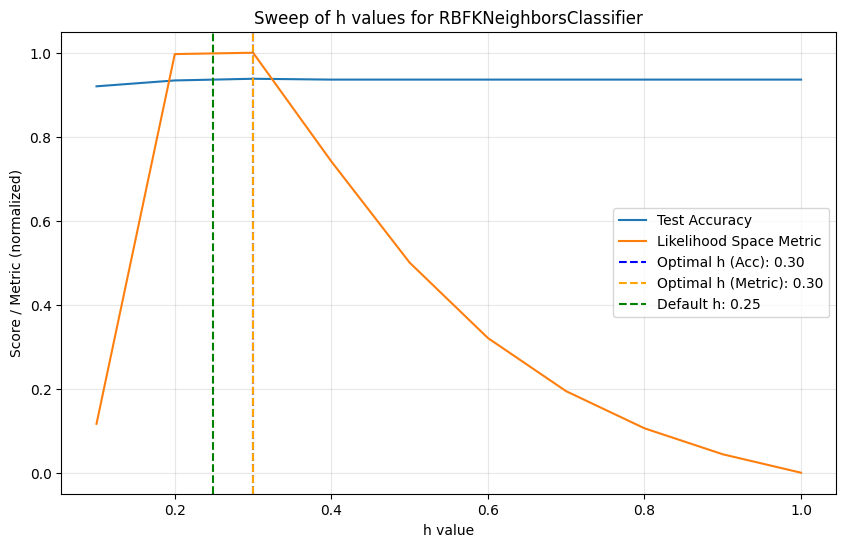


Sweeping h values for Support Vector RBF-kNN...


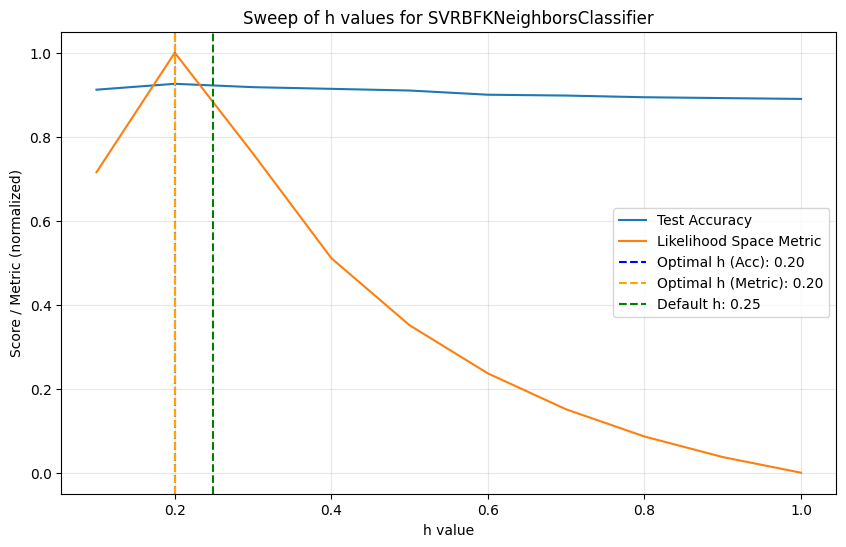


Results Summary:
Reference RBF-kNN:
  h for max accuracy: 0.300
  h for max avg centroid distance: 0.300
  default h: 0.249

Support Vector RBF-kNN:
  h for max accuracy: 0.200
  h for max avg centroid distance: 0.200
  default h: 0.249


((np.float64(0.0), np.float64(-0.051056649192925435)),
 (np.float64(0.0), np.float64(0.0489433508070746)))

In [107]:
def intra_class_distance(Q, y):
    """Compute the average intra-class distance in likelihood space"""
    _, intra_avg = sample_spread(Q, y)
    return intra_avg

test_likelihood_metric(intra_class_distance)

Sweeping h values for Reference RBF-kNN...


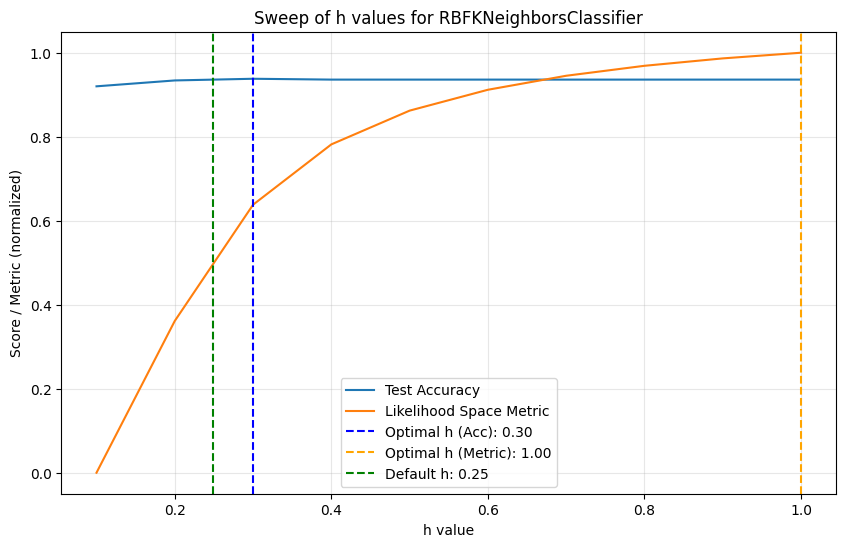


Sweeping h values for Support Vector RBF-kNN...


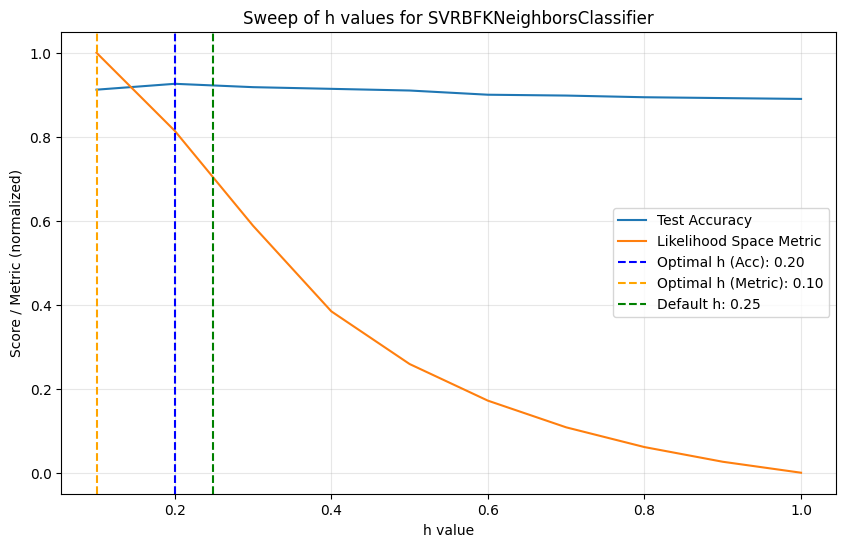


Results Summary:
Reference RBF-kNN:
  h for max accuracy: 0.300
  h for max avg centroid distance: 1.000
  default h: 0.249

Support Vector RBF-kNN:
  h for max accuracy: 0.200
  h for max avg centroid distance: 0.100
  default h: 0.249


((np.float64(0.7), np.float64(-0.051056649192925435)),
 (np.float64(-0.1), np.float64(0.0489433508070746)))

In [108]:
def combined_distance(Q, y):
    """Compute the overall average pairwise distance in likelihood space"""
    inter_avg, intra_avg = sample_spread(Q, y)
    return inter_avg + intra_avg

test_likelihood_metric(combined_distance)